# Challenge 0: Does this Run? :)

In [2]:
import jax
import numpy as np
from jax import numpy as jnp
from matplotlib import pyplot as plt
%matplotlib inline

# Challenge 1.

JAX is basically numpy on steroids. Here you are able to put it to the test! Show off your best numpy skills, try to find somewhere where JAX and numpy syntax is different.

In [3]:
M = jnp.array(np.random.randn(10, 10))

# Challenge 2: Gradients Can Be Annoying

Plot the derivative of $sin(x/2\pi)$

Tip: use `jax.vmap` to calculate for multiple x's at once

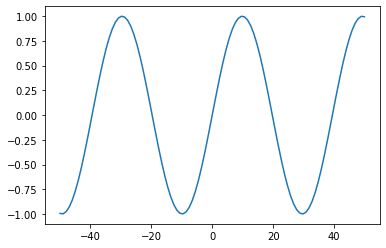

In [4]:
x = jnp.linspace(-50, 50, 100)

plt.plot(x, jnp.sin(x/(2*jnp.pi)))



Plot the all **n** derivatives of an n-th order polynomial. Typ: use `functools.partial` to get rid of the roots argument and `jax.vmap`.

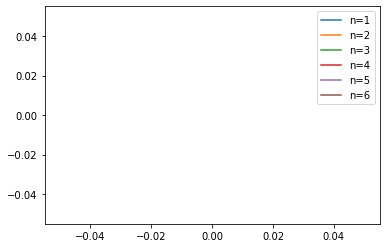

In [518]:
n = 6
roots = np.random.uniform(-3, 3, n).astype(np.float64)
def nth_order_polynomial(x, roots):
    y = 1
    for r in roots:
        y = y*(x-r)
    return y


# n-th order derivatives of this function?
for i in range(n):
    # TODO your code goes here
    x=[];y=[]; 
    plt.plot(x, y, label=f'n={i+1}')
plt.legend()


# Challenge 4: Linear Regression

Implement linear regression using stochastic gradient descent in JAX. 

Bonus: can you do this with least squares?

In [7]:
# dataset for linear regression
def generate_data(d, N):
    x = np.random.uniform(-1,1, (N, d))
    theta = np.random.uniform(-1,1, (d,1))
    y = x @ theta
    theta_ = np.random.uniform(-1,1, (d,1))
    return x, y, theta, theta_

x, y, theta, theta_ = generate_data(20, 500)

def vis_lines(theta, theta_):
    x = np.linspace(-2, 2, 100)
    y = theta[0, 0]*x + theta[1,0]
    y_ = theta_[0,0]*x+ theta_[1,0]
    plt.plot(x, y, label='gt')
    plt.plot(x, y_, label='pred')
    plt.legend()

print(x.shape, y.shape, theta.shape, theta_.shape)

(500, 20) (500, 1) (20, 1) (20, 1)


MSE loss: 3.6995561122894287


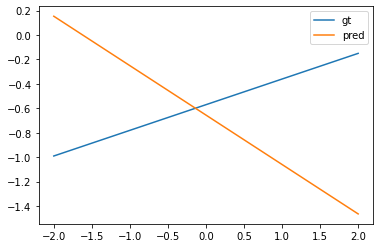

In [3]:
@jax.jit
def predict(x, theta):
    return x@theta

def mse(x, theta, y):
    y_ = predict(x, theta)
    return ((y-y_)**2).mean()

grad_func = jax.grad(mse, argnums=[1]) # returns a function which takes the same arguments as the wrapped one


# returns tuple of gradients with respect to arguments of function
grad, = grad_func(x, theta, y)

# for practicality, this is also available
loss, (grad,) = jax.value_and_grad(mse, argnums=[1])(x,theta_, y)
print(f"MSE loss: {loss}")



vis_lines(theta, theta_)

MSE: 3.6995561122894287


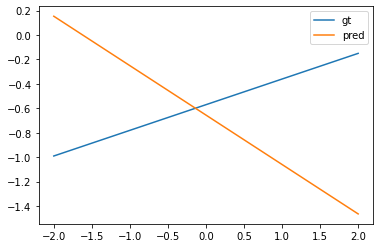

In [4]:
# stupid loop to optimize our model
for _ in range(50):
    # TODO your code here
    pass

print(f"MSE: {loss}")
vis_lines(theta, theta_)

# Challenge 4: Making Use of Hessians

Normally we use first-order information when doing gradient descent, so:
$$
\theta_{t+1} = \theta_t + \nabla_\theta f
$$


Using Taylor expansion, we can approximate the function $f(x)$. Similarly, we can approximate the gradient of the function via Taylor (you can look at h as being our update step):

$$
\nabla_x f(x+h) \approx \nabla_x f   + \nabla_x^2 f h
$$

Questions:
* How can we use this to improve convergence time for our quadratic function?
* In how many steps did it converge to the solution?

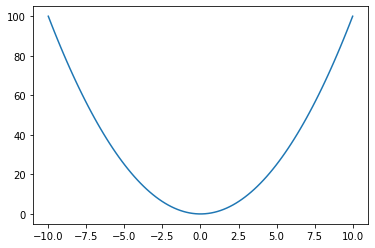

In [4]:
d = 10

@jax.jit
def square(x):
    return (x**2).sum(-1)


x = np.linspace(-10, 10, 100)[:, None]
# slice at dim=0
plt.plot(x, square(x))



Converged in 299 steps, 0.001, [10. 10. 10. 10. 10. 10. 10. 10. 10. 10.]


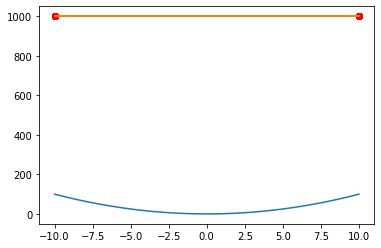

In [5]:
### don't touch ! ###
x0 = jnp.array([10.0]*d)
f = square
x_ = x0
trajx = [x0[0]]
trajy = [f(x0)]
err = 1e-3
#####################

for i in range(300):
    
    #### TODO update this part
    g = jax.grad(f)(x_)
    x_ -= g
    #### TODO ####

    trajx.append(x_[0])
    trajy.append(f(x_))

    if trajy[-1] < err:
        break

print(f"Converged in {i} steps, {err}, {x_}")
plt.plot(x, f(x))
plt.plot(trajx, trajy)
plt.scatter(trajx, trajy, color='red')

# Challenge 5: Implement VAEs in JAX

Implement a VAE to learn a generative model for the MNIST dataset. Our goal is to optimize the ELBO, ie. implement this loss function:

$$
\mathcal{L}(\theta, \phi) = -\mathbb{E}[p_\phi(x | z)] +  \mathbb{KL}[q_\theta(z | x) || p(z)]  
$$

In plain words, on a training step we are sampling from a Gaussian outputted by the encoder, $q(z | x)$, we feed the samples through the decoder $p(x | z)$ to obtain probabilities (or logits in our case).


Most of the code is already there, you need to finish implementing:
* `__call__` of the VAE class
* `generate` of the VAE class
* `loss` function


In [558]:
import flax
from typing import Optional
from jax import numpy as jnp


@jax.vmap
def kl_divergence(mean, logvar):
  return -0.5 * jnp.sum(1 + logvar - jnp.square(mean) - jnp.exp(logvar))

@jax.vmap
def binary_cross_entropy_with_logits(logits, labels):
  logits = flax.linen.log_sigmoid(logits)
  return -jnp.sum(labels * logits + (1. - labels) * jnp.log(-jnp.expm1(logits)))


@jax.jit
def loss(logits, mean, logvar):
  # TODO your code here, use the upper two losses
  pass

from typing import Sequence
class Sequential(flax.linen.Module):
  layers: Sequence[flax.linen.Module]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x


class MLPCompact(flax.linen.Module):
    # here, ordering is preserved
    num_hidden: int
    hidden_size: int
    outputs: int
    act_function: Optional[str] = 'relu'
    

    def forward(self, x):
      act_function = getattr(flax.linen, self.act_function)
      for _ in range(self.num_hidden):
          x = flax.linen.Dense(self.hidden_size)(x)
          x = act_function(x)
      # don't apply act in last layer
      x = flax.linen.Dense(self.outputs)(x)
      return x

    @flax.linen.compact
    def __call__(self, x):
      return self.forward(x)

class Decoder(MLPCompact):

    def setup(self):
        return

    @flax.linen.compact
    def __call__(self, x):
      x = super().forward(x)
      return x

# make use of this for reparametrization trick (rsample)
from numpyro.distributions import Normal


class VAE(flax.linen.Module):
  latents: int
  outputs: int
  
  def setup(self):
    self.encoder = MLPCompact(3, 128, self.latents*2)
    self.decoder = Decoder(3, 256, outputs=self.outputs)

  def __call__(self, key, x, deterministic=False):
    """
      returns: x, z, mu, logvar
    """

    gauss_params = self.encoder(x)
    mu, logvar = jnp.split(gauss_params, 2, -1)
    sigma = jnp.sqrt(jnp.exp(logvar))
    # TODO your code here

  def generate(self, key, samples):
    """
      returns: x
    """
    # generate samples from p(z) and decode them
    # TODO your code here
    pass

In [555]:
import optax

# vae template
vae = VAE(20, 28*28)
# create optimizer
optimizer = optax.adam(1e-3)
params = None
rk1, rk2 = jax.random.split(key)
params = vae.init(rk1, rk2, jnp.ones((64, 28*28)))
opt_state = optimizer.init(params)

# this returns a function!
def construct_training_step(model, optimizer):
  # model forward
  def model_loss(params, key, image):
    logits, z, mean, logvar = model.apply(params, key, image)
    loss = jnp.mean(binary_cross_entropy_with_logits(logits, image) + kl_divergence(mean, logvar))
    return loss
  
  grad_func = jax.value_and_grad(model_loss, argnums=0)
  # this is the function that we call in the end
  def update_func(params, opt_state, key,  image):
    loss, grads = grad_func(params, key, image)
    updates, opt_state = optimizer.update(grads, opt_state)
    return loss, updates, opt_state
  return jax.jit(update_func)

training_step = construct_training_step(vae, optimizer)


In [ ]:
from tqdm.notebook import tqdm
import optax

for e in range(20):
  tqdm_iter = tqdm(enumerate(ds))
  for i, batch in tqdm_iter:
    image  = batch["image"]
    
    image = image.reshape(-1, 28*28)

    key, _ = jax.random.split(key)
    logits, z, mean, logvar = vae.apply(params, key, image)

    # this is equivalent to  .backward and optimizer.step in PyTorch
    loss, updates, opt_state = training_step(params, opt_state, key, image)
    params = optax.apply_updates(params, updates)
    
    tqdm_iter.set_description(f"Epoch {e:5d}, batch {i:5d}, loss={loss:10.5f}")


Now we plot samples from $p(z)$

In [ ]:
# now we sample from p(z)
key, _ = jax.random.split(key)
imgs = vae.apply(params, key, 2, method=vae.generate)
plt.imshow(imgs[0])

# Bonus: Meta-learning with MAML

In [ ]:
import functools
from jax.tree_util import tree_multimap
import numpy as np



def mse(params, inputs, targets):
    # Computes average loss for the batch
    predictions = mlp.apply(params, inputs)
    return jnp.mean((targets - predictions)**2)

def inner_update(params, x1, y1, alpha=.1):
    """
        This is the expression with which we obtain \theta - grad(inner_loss)
    """
    grads = jax.grad(mse)(params, x1, y1)
    inner_sgd_fn = lambda g, state: (state - alpha*g)
    return tree_multimap(inner_sgd_fn, grads, p)

def maml_loss(p, x1, y1, x2, y2):
    """
        This is the outer loss
    """
    p2 = inner_update(p, x1, y1)
    return mse(p2, x2, y2)

# returns scalar for all tasks.
def batch_maml_loss(p, x1_b, y1_b, x2_b, y2_b):
    task_losses = jax.vmap(functools.partial(maml_loss, p))(x1_b, y1_b, x2_b, y2_b)
    return jnp.mean(task_losses)


# this returns a function!
def construct_training_step(model, optimizer):
  # model forward
  grad_func = jax.value_and_grad(batch_maml_loss)
  # this is the function that we call in the end
  def update_func(params, opt_state, x1_b, y1_b, x2_b, y2_b):
    l, grads = grad_func(params, x1_b, y1_b, x2_b, y2_b)
    updates, opt_state = optimizer.update(grads, opt_state)
    return l, updates, opt_state
  return jax.jit(update_func)

def sample_tasks(outer_batch_size, inner_batch_size):
    # Sample random sinusoid functions
    As = []
    phases = []
    for _ in range(outer_batch_size):        
        As.append(np.random.uniform(low=0.1, high=.5))
        phases.append(np.random.uniform(low=0., high=np.pi))
    def get_batch():
        xs, ys = [], []
        for A, phase in zip(As, phases):
            x = np.random.uniform(low=-5., high=5., size=(inner_batch_size, 1))
            y = A * np.sin(x + phase)
            xs.append(x)
            ys.append(y)
        return np.stack(xs), np.stack(ys)
    x1, y1 = get_batch()
    x2, y2 = get_batch()
    return x1, y1, x2, y2





In [ ]:
mlp = MLPCompact(2, 64, 1)
params  = mlp.init(key, jnp.ones((64,1)))
optimizer = optax.adam(1e-2)
opt_state = optimizer.init(params)
training_step = construct_training_step(mlp, optimizer)


In [ ]:
np_batched_maml_loss = []
K=20
tqdm_iter = tqdm(range(20000))
for i in tqdm_iter:
    x1_b, y1_b, x2_b, y2_b = sample_tasks(4, K)
    l, updates, opt_state = training_step(params, opt_state, x1_b, y1_b, x2_b, y2_b)
    np_batched_maml_loss.append(l)
    params = optax.apply_updates(params, updates)
    tqdm_iter.set_postfix_str(f"loss:{l:10.5f}")

In [ ]:
# batch the inference across K=100
x = np.linspace(-5,5,100).reshape((100, 1)) # (k, 1)
targets = np.sin(x)
predictions = jax.vmap(functools.partial(mlp.apply, params))(x)
plt.plot(x, predictions, label='pre-update predictions')
plt.plot(x, targets, label='target')

x1 = np.random.uniform(low=-5., high=5., size=(K,1))
y1 = 1. * np.sin(x1 + 0.)

net_params = params
for i in range(1,5):
    net_params = inner_update(net_params, x1, y1)
    predictions = jax.vmap(functools.partial(mlp.apply, net_params))(x)
    plt.plot(x, predictions, label='{}-shot predictions'.format(i))
plt.legend()